# Data Loading: LMDB Database

## Overview

This example shows you how to use the data that is stored in LMDB database, in Caffe and Caffe 2 formats, with DALI.

## Caffe LMDB Format

To use data that is stored in LMDB in the Caffe format, we need to use the `readers.Caffe` operator. In addition to the arguments that are common to all readers, such as `random_shuffle`, the operator takes `path` argument, which is the path to the directory where LMDB is stored.

1. We will read images stored in the Caffe format, decode them, and prepare them for ingestion in a DL framework.

Processing the images involves cropping, normalizing, and completing the `HWC` -> `CHW` conversion process.

The `DALI_EXTRA_PATH` environment variable should point to the location where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded.

**Important**: Ensure that you check out the correct release tag that corresponds to the installed version of DALI.

In [1]:
import os
from pathlib import Path

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import nvidia.dali.experimental.dynamic as ndd

dali_extra_dir = Path(os.environ["DALI_EXTRA_PATH"])
db_folder = dali_extra_dir / "db" / "lmdb"
batch_size = 9

In [2]:
reader = ndd.readers.Caffe(path=db_folder)

for jpegs, labels in reader.next_epoch(batch_size=batch_size):
    images = ndd.decoders.image(jpegs, device="gpu")
    output = ndd.crop_mirror_normalize(
        images,
        dtype=ndd.float32,
        crop=(224, 224),
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        crop_pos_x=ndd.random.uniform(range=(0, 1)),
        crop_pos_y=ndd.random.uniform(range=(0, 1)),
    )
    break  # Run once

2. To visualize the results, use the `matplotlib` library, which expects images in `HWC` format, but the output is in `CHW`.

   **Note**: `CHW` is the preferred format for most Deep Learning frameworks.
   
3. For the visualization purposes, transpose the images back to the `HWC` layout.

In [3]:
def show_images(image_batch: ndd.Batch):
    columns = 3
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(20, (20 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j, img in enumerate(image_batch):
        plt.subplot(gs[j])
        plt.axis("off")
        img_chw = np.asarray(img.cpu())
        img_hwc = np.transpose(img_chw, (1, 2, 0)) / 255.0
        plt.imshow(img_hwc)
    plt.show()

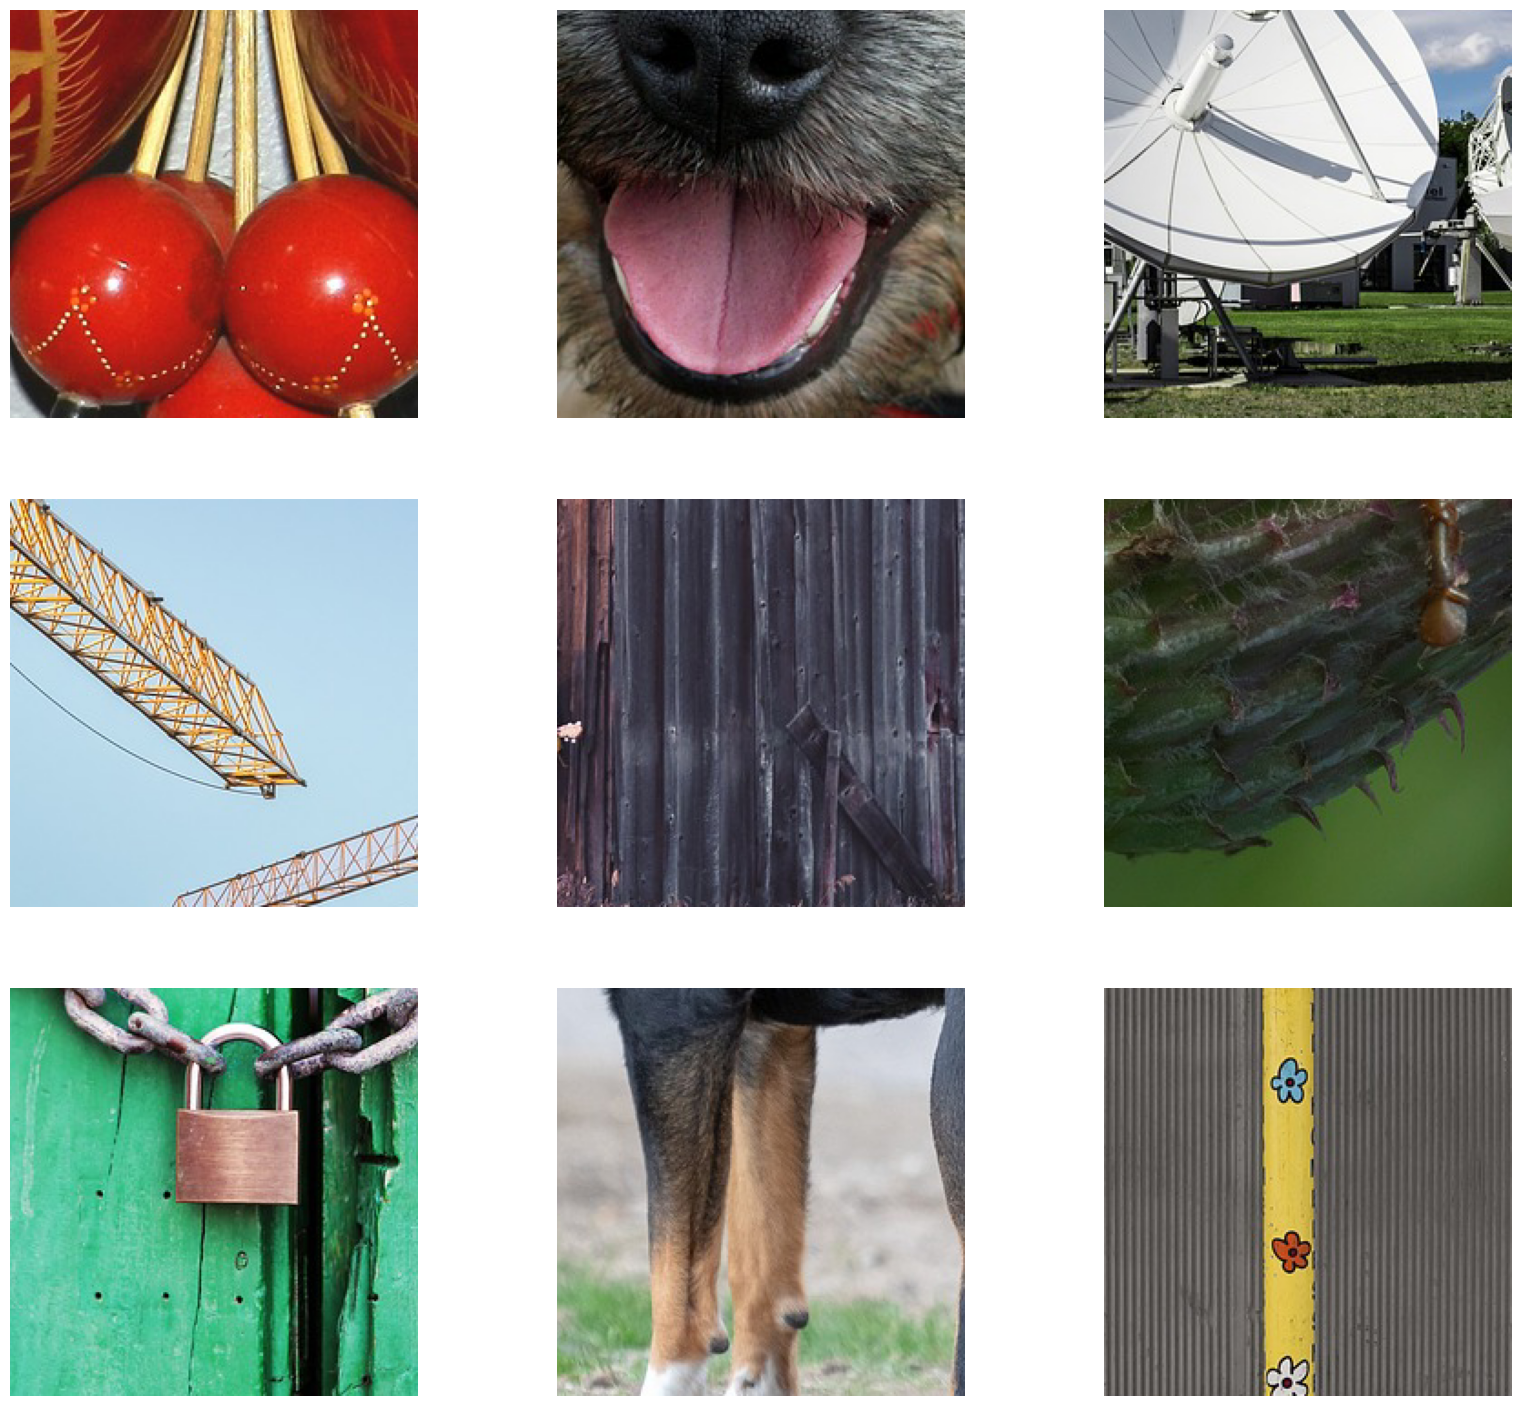

In [4]:
show_images(output)

## Caffe 2 LMDB Format

To use the data that is stored in LMDB in the Caffe 2 format, we need to use the `readers.Caffe2` operator. Like the `readers.Caffe` operator, in addition to the arguments that are common to all readers, such as `random_shuffle`, this operator takes the `path` argument, which is the path to the directory where LMDB is stored.

1. Read images stored in the Caffe 2 format, decode them and prepare them for ingestion in a DL framework. 

   Processing the images involves cropping, normalizing, and completing the `HWC` -> `CHW` conversion process.

In [5]:
db_folder_c2 = dali_extra_dir / "db" / "c2lmdb"

reader = ndd.readers.Caffe2(path=db_folder_c2)

for jpegs, labels in reader.next_epoch(batch_size=batch_size):
    images = ndd.decoders.image(jpegs, device="gpu")
    output_c2 = ndd.crop_mirror_normalize(
        images,
        dtype=ndd.float32,
        crop=(224, 224),
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
    )
    break  # Run once

2. To visualize the results, you can use the `matplotlib` library, which expects images in `HWC` format, but the output is in `CHW`.

   **Note**: `CHW` is the preferred format for most Deep Learning frameworks.
   
3. For the visualization purposes, transpose the images back to the `HWC` layout.

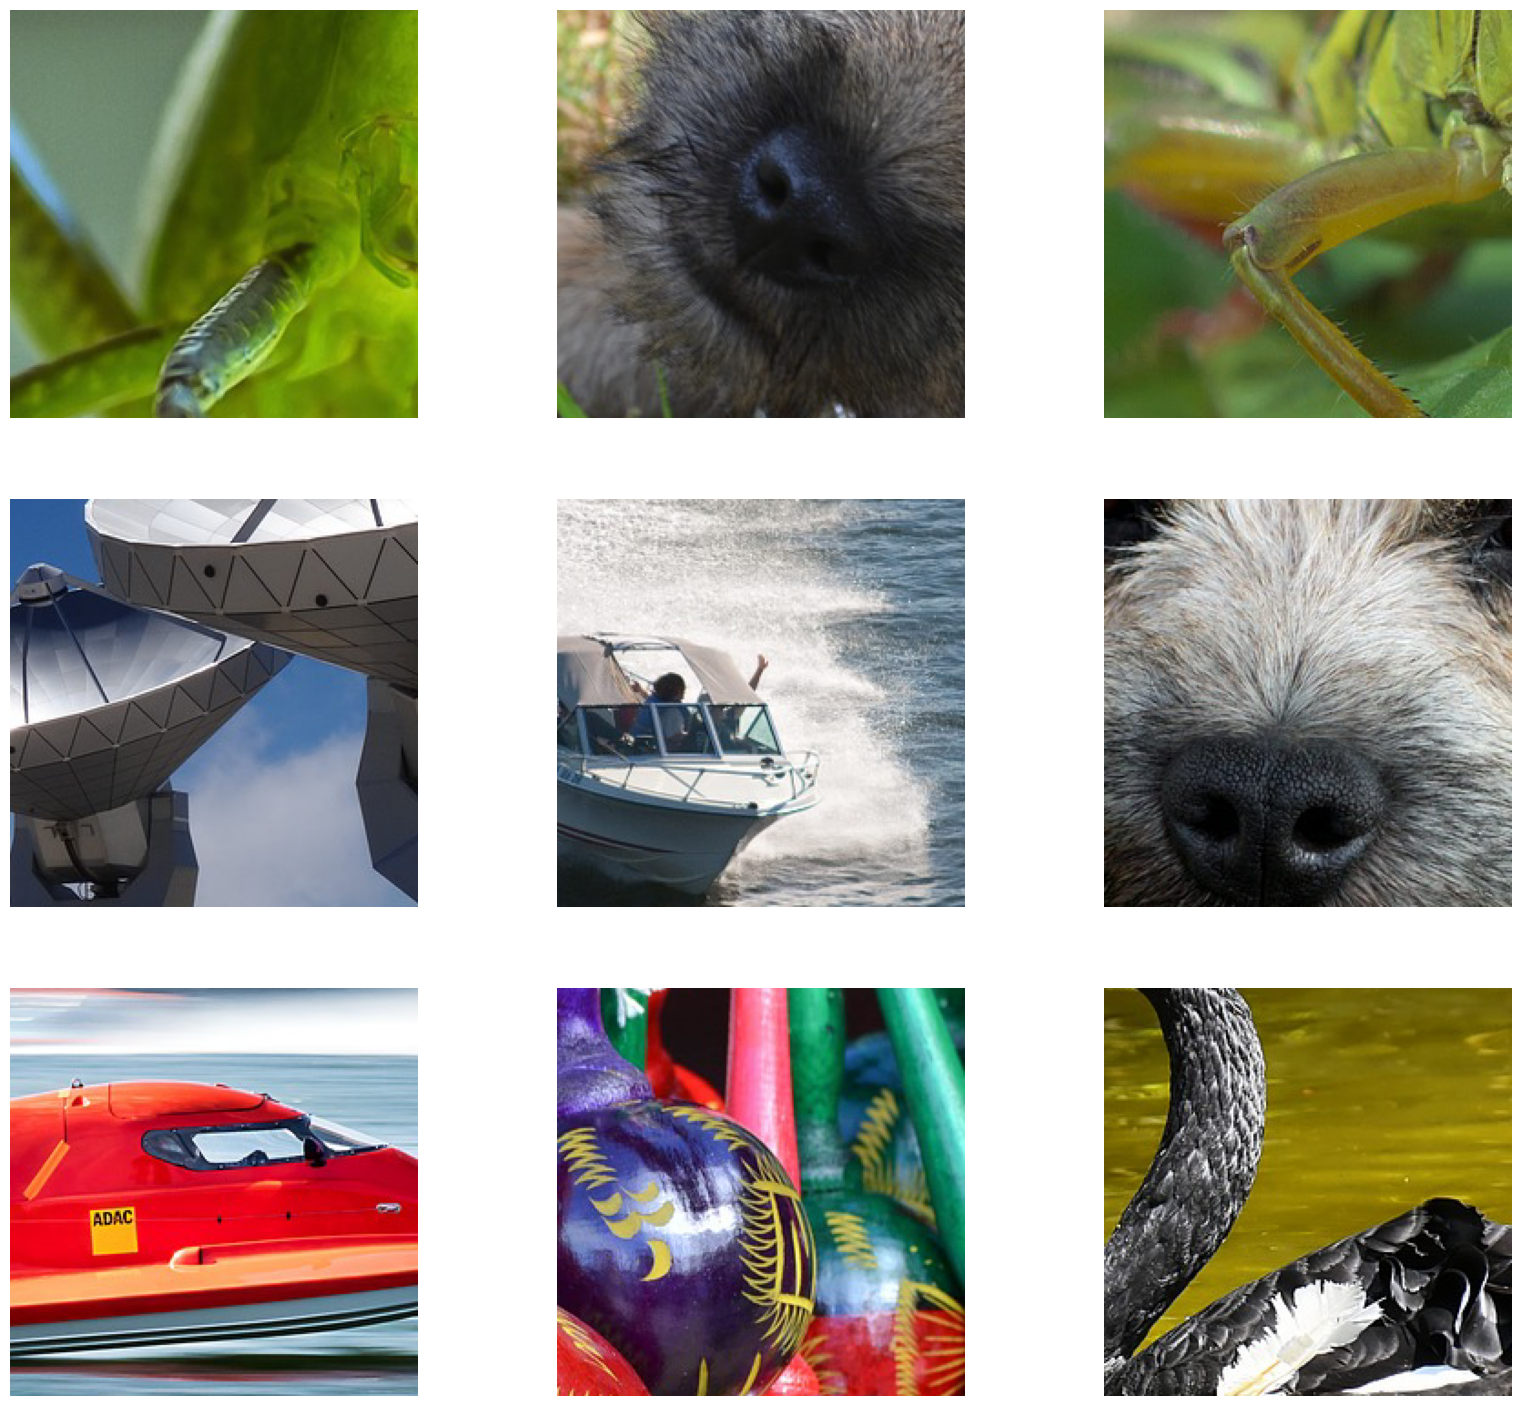

In [6]:
show_images(output_c2)